# Infrastructure Damage Analysis Post-Earthquake
By: [Crystal Villa](https://www.linkedin.com/in/crystal-villa-5a181b247/)

### Mapping Earthquake Impact: Data-Driven Insights from the 2010 Haiti Disaster

This project aims to assess urban infrastructure changes in Port-au-Prince, Haiti, following the catastrophic earthquake on [January 12, 2010](https://en.wikipedia.org/wiki/2010_Haiti_earthquake). Given that this seismic event ranks among the most destructive in modern history, analyzing the spatial patterns of damage and recovery is critical for enhancing disaster response and urban planning. Although various factors influence infrastructure changes after an earthquake, this study concentrates on geospatial analysis using datasets from the USGS.

The data science lifecycle highlights the importance of effective data collection, management, and visualization. This project delves into the impact of the 2010 Haiti Earthquake, leveraging geospatial datasets from sources such as the USGS Earthquake API and OpenStreetMap. Participants will develop skills to collect, clean, and integrate earthquake and infrastructure data to evaluate damage to roads, bridges, and buildings. By employing interactive mapping and clustering methods, they will visualize the severity of damage and identify key areas requiring disaster response and recovery efforts. Through the study of this real-world event, participants will gain valuable insights into how data science contributes to earthquake impact analysis, resource allocation, and resilience planning.


Aligned with the principles of open science, this project ensures that all datasets are accessible, well-documented, and adhere to FAIR (Findable, Accessible, Interoperable, and Reusable) guidelines. This commitment supports collaboration, enables data-driven decision-making, and contributes to strengthening infrastructure resilience in earthquake-prone areas. Ultimately, the research aims to improve disaster response, guide reconstruction efforts, and promote sustainable urban development in Haiti.

### 2. Learning Objectives
By the end of this lesson, students will:
*   Extract and integrate data from USGS ShakeMap (earthquake intensity) and OSM (infrastructure data).
*   Visualize the spatial distribution of roads and buildings impacted using an interactive Folium map.
*   Analyze the relationship between earthquake magnitude and distance to the nearest building plot.
*   Summarize earthquake magnitudes using a bar chart.

### 3. Why This Lesson Matters
Understanding earthquake impact assessment is crucial for disaster response planning and urban infrastructure resilience. By using Python and open-source GIS tools, students will learn how data science aids in real-world crisis management.

### 1. Installing and Importing Necessary Libraries


In [ ]:
!pip install osmnx geopandas folium requests matplotlib pandas shapely rasterio fiona fastkml shapely zipfile36


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### What's happening here?
Before we dive into the data, we need our toolbox ready! Think of these libraries as our digital Swiss Army knife for mapping and analyzing earthquake impacts.

`osmnx`: Used to retrieve and analyze OpenStreetMap (OSM) data, such as roads and buildings.

`geopandas`: Provides tools for handling geospatial data.

`folium`: Helps create interactive maps.

`requests`: Enables HTTP requests to fetch data from APIs.

`matplotlib` and `pandas`: Used for data visualization and manipulation.

`shapely`: Provides tools for geometric operations.

`rasterio`: Handles raster (satellite) data.

`fiona  `and`  fastkml`: Read geospatial vector data.

`zipfile36`: Manages compressed files.

## 2. Downloading Earthquake Data from USGS APA

### Why This is Important

Here, we retrieve earthquake data using the United States Geological Survey (USGS) Earthquake API. We specify a time range of January 12–13, 2010, focusing on the Haiti earthquake. The latitude and longitude boundaries define the affected area around Port-au-Prince

*   We define a search area right around Port-au-Prince, Haiti, where the big one struck in 2010.
*   The API response gives us detailed earthquake data in GeoJSON format, perfect for mapping.
*   We save it for later, so we can work with it even without internet access.

In [ ]:
import requests
import json

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2010-01-12",
    "endtime": "2010-01-13",
    "minlatitude": 18.4,
    "maxlatitude": 18.8,
    "minlongitude": -72.6,
    "maxlongitude": -72.2,
    "minmagnitude": 7.0
}

response = requests.get(url, params=params)
data = response.json()

with open("port_au_prince_earthquake.geojson", "w") as f:
    json.dump(data, f)

print(f"Earthquake data downloaded successfully! {len(data['features'])} records found.")


Earthquake data downloaded successfully! 1 records found.


### Why is this important?
Alright, so we downloaded the earthquake data… but what’s inside? Let's crack it open with GeoPandas, the ultimate geospatial data tool!

*   `.read_file()` reads the GeoJSON file into a format that we can analyze.
*   `.head()` gives us a sneak peek at the first few rows.
*   `.info()` tells us what kind of data we’re working with (like magnitude, location, etc.).

In [ ]:
import geopandas as gpd

gpd.options.io_engine = "pyogrio"

earthquake_gdf = gpd.read_file("port_au_prince_earthquake.geojson")

print(earthquake_gdf.head())
print(earthquake_gdf.info())


           id  mag                       place           time        updated  \
0  usp000h60h    7  10 km SE of Léogâne, Haiti  1263333190060  1702920267697   

     tz                                                url  \
0  None  https://earthquake.usgs.gov/earthquakes/eventp...   

                                              detail  felt  cdi  ...  \
0  https://earthquake.usgs.gov/fdsnws/event/1/que...   956  9.1  ...   

                                       sources  \
0  ,us,us,choy,gcmt,duputel,gcmt,atlas,iscgem,   

                                               types  nst  dmin   rms   gap  \
0  ,associate,dyfi,focal-mechanism,general-link,g...  500  None  0.97  22.7   

  magType        type                               title  \
0     mwc  earthquake  M 7.0 - 10 km SE of Léogâne, Haiti   

                      geometry  
0  POINT Z (-72.571 18.443 13)  

[1 rows x 28 columns]
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2

### 3. Retrieving Road Data from OpenStreetMap

### Why is this important?

Ever wondered how Google Maps knows where roads are? It all comes from OpenStreetMap—a crowdsourced treasure trove of location data!

*   `graph_from_place()` pulls all the drivable roads in Port-au-Prince.
*   We convert them into a GeoDataFrame (so we can analyze them later).
*   We save them as a GeoJSON file to use in our final map!

In [ ]:
import osmnx as ox

place_name = "Port-au-Prince, Haiti"

roads = ox.graph_from_place(place_name, network_type="drive")

roads_gdf = ox.graph_to_gdfs(roads, nodes=False)

roads_gdf.to_file("port_au_prince_roads.geojson", driver="GeoJSON")

print(f"Successfully retrieved {len(roads_gdf)} roads in Port-au-Prince!")


Successfully retrieved 38503 roads in Port-au-Prince!


## 5. Retrieving Building Data from OpenStreetMap

### Why this Matters
What about the buildings? Knowing where houses, schools, and hospitals were before the earthquake helps us understand the impact.

*   We use `osmnx.features_from_place()` to pull all the buildings in Port-au-Prince
*   Just like with roads, we convert and save the data as a GeoJSON file.

In [ ]:
import osmnx as ox

place_name = "Port-au-Prince, Haiti"

tags = {"building": True}

buildings_gdf = ox.features_from_place(place_name, tags=tags)

buildings_gdf.to_file("port_au_prince_buildings.geojson", driver="GeoJSON")

print(f"Successfully retrieved {len(buildings_gdf)} buildings in Port-au-Prince!")


Successfully retrieved 176724 buildings in Port-au-Prince!


Here, we're switching `GeoPandas`' file-reading engine from `Fiona` to `Pyogrio`. Why? Because Pyogrio can be up to 10 times faster when reading spatial data. But some file types still work better with Fiona, so we make sure to switch back if needed. Think of it as choosing between a race car and an all-terrain vehicle one is faster, but the other works in more situations!

In [ ]:
import geopandas as gpd

gpd.options.io_engine = "pyogrio"

print("GeoPandas is now using pyogrio instead of fiona!")

GeoPandas is now using pyogrio instead of fiona!


In [ ]:
import geopandas as gpd
gpd.options.io_engine = "fiona"

## 6. The Classic Chart and Mapping Tool
This section brings all the data together into a single visualization, illustrating the impact of the earthquake on infrastructure in Port-au-Prince. Using `Matplotlib`, roads are plotted in gray, buildings in brown, and earthquake locations in red (if data is available). This layering technique highlights spatial relationships, allowing for a clear visual understanding of how the earthquake may have affected urban areas.

The purpose of this visualization is to transform raw geospatial data into an interpretable format. Instead of analyzing large datasets through tables and numbers, this map provides immediate insights into which areas were most affected. Adding a title and a legend ensures clarity, making the visualization useful for analysis and decision-making. This approach mirrors real-world disaster response efforts, where clear, data-driven maps play a crucial role in assessing damage and planning recovery efforts.

### Why `Matplotlib` is Important Here


*   It helps us visualize spatial data in a controlled environment. Unlike `Folium`, which is interactive, `Matplotlib` lets us customize every detail for a static but highly customizable map

*   We can overlay multiple layers like roads, buildings, and earthquakes, making it a great tool for quick analysis before moving to an interactive map.

*   It’s widely used in scientific computing—if you’re doing research, `Matplotlib` is essential for making publication-quality visualizations.


<ipython-input-9-211875a2e25b>:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


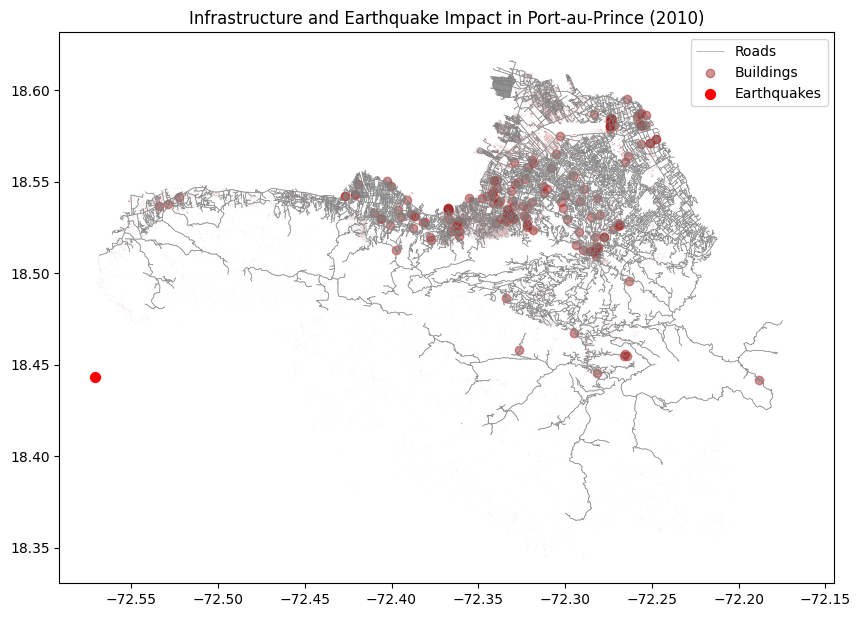

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

roads_gdf.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.7, label="Roads")

buildings_gdf.plot(ax=ax, color="brown", alpha=0.5, label="Buildings")

if not earthquake_gdf.empty:
    earthquake_gdf.plot(ax=ax, color="red", markersize=50, label="Earthquakes")
else:
    print("No earthquake data found in GeoJSON. Skipping earthquake plot.")

plt.legend()
plt.title("Infrastructure and Earthquake Impact in Port-au-Prince (2010)")

plt.show()

### 7. Loading Earthquake Data

*   This loads a GeoJSON file containing earthquake data.

*   It enables you to access detailed earthquake attributes such as magnitude, coordinates, and depth.

*  The data can be mapped alongside roads and buildings to assess damage distribution.

In [ ]:
import json

with open("port_au_prince_earthquake.geojson", "r") as f:
    earthquake_data = json.load(f)

print(earthquake_data)

{'type': 'FeatureCollection', 'metadata': {'generated': 1742436257000, 'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2010-01-12&endtime=2010-01-13&minlatitude=18.4&maxlatitude=18.8&minlongitude=-72.6&maxlongitude=-72.2&minmagnitude=7.0', 'title': 'USGS Earthquakes', 'status': 200, 'api': '1.14.1', 'count': 1}, 'features': [{'type': 'Feature', 'properties': {'mag': 7, 'place': '10 km SE of Léogâne, Haiti', 'time': 1263333190060, 'updated': 1702920267697, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/usp000h60h', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000h60h&format=geojson', 'felt': 956, 'cdi': 9.1, 'mmi': 9.022, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 1624, 'net': 'us', 'code': 'p000h60h', 'ids': ',us2010rja6,usp000h60h,choy20100112215310,gcmtc201001122153a,duputel201001122153a,gcmt20100112215310,atlas20100112215310,iscgem14226221,', 'sources': ',us,us,choy,gcmt,duputel,gcmt,at

### 8. Checking the Haiti Data Folder
*   This checks whether the satellite imagery and other essential files are available.

*   If the folder is missing, the script alerts you to check your Google Drive.

*  This is crucial for ensuring the data is accessible before running further analysis.

In [ ]:
import os

haiti_data_path = "/content/drive/My Drive/Haiti Data"
if os.path.exists(haiti_data_path):
    print("'Haiti Data' folder found!")
    print("Files in 'Haiti Data':", os.listdir(haiti_data_path))
else:
    print("'Haiti Data' folder not found! Check your Google Drive.")


'Haiti Data' folder found!
Files in 'Haiti Data': ['haiti_after.tif', 'haiti_before.tif', 'shakemap (1).kmz', 'dyfi_plot_atten.json']


### 9. Loading Pre- and Post-Disaster Satellite Images

This part of the code is essential because it loads georeferenced raster images of the region before and after the earthquake. These images provide crucial visual data for damage assessment by comparing infrastructure conditions pre- and post-disaster


*   Uses `Rasterio`, a library for handling geospatial raster data.
*   Reads pre- and post-disaster images, which will be used for damage assessment.
*   Stores image data as arrays, allowing for processing and visualization.

In [ ]:
pre_disaster_img = "/content/drive/My Drive/Haiti Data/haiti_before.tif"
post_disaster_img = "/content/drive/My Drive/Haiti Data/haiti_after.tif"


In [ ]:
import rasterio

with rasterio.open(pre_disaster_img) as src_pre:
    pre_array = src_pre.read(1)
    pre_transform = src_pre.transform

with rasterio.open(post_disaster_img) as src_post:
    post_array = src_post.read(1)
    post_transform = src_post.transform

print("Satellite images loaded successfully!")


Satellite images loaded successfully!


### 10. Visualizing Pre- and Post-Earthquake Images

Once we’ve loaded the satellite images, the next step is to visualize them side by side. This allows us to observe the before-and-after effects of the earthquake on Port-au-Prince. Comparing these images helps in damage assessment, as we can see changes in the urban landscape, such as collapsed buildings, altered roads, or shifts in vegetation.


*   Loads satellite images into arrays for further processing.

*   Uses rasterio, a powerful library for handling geospatial raster data
*   Extracts transformation metadata to understand the spatial reference of the images.
*   Prepares the data for visualization and further analysis, such as damage detection.



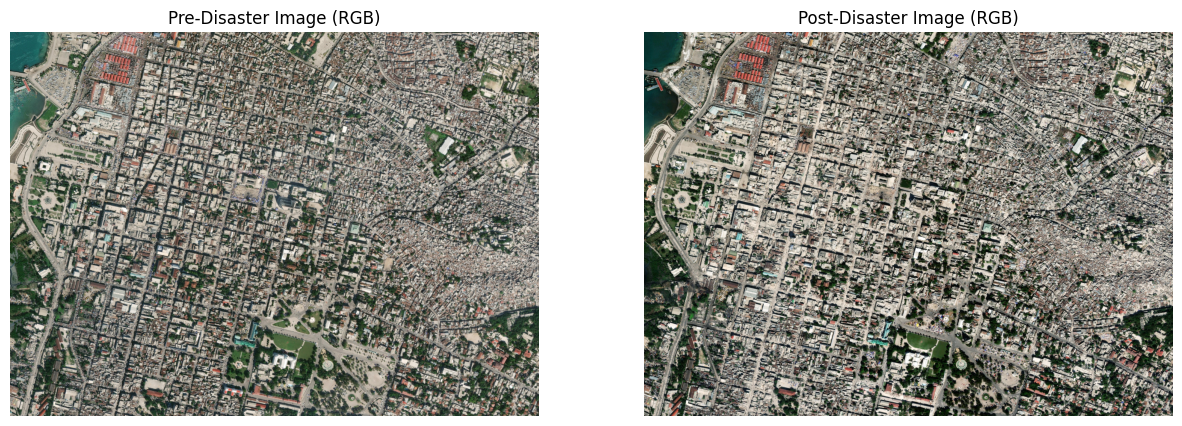

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open(pre_disaster_img) as src_pre:
    pre_array = src_pre.read([1, 2, 3])
    pre_array = np.moveaxis(pre_array, 0, -1)


with rasterio.open(post_disaster_img) as src_post:
    post_array = src_post.read([1, 2, 3])
    post_array = np.moveaxis(post_array, 0, -1)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(pre_array)
ax[0].set_title("Pre-Disaster Image (RGB)")
ax[0].axis("off")

ax[1].imshow(post_array)
ax[1].set_title("Post-Disaster Image (RGB)")
ax[1].axis("off")

plt.show()


### 11. Extracting Earthquake Data from KMZ Files

This code is responsible for extracting geographic earthquake data stored in a KMZ file. Since KMZ files are compressed KML files, they must be unzipped before we can analyze their contents. By automating this process, we ensure that the earthquake data is accessible for mapping and visualization. The extracted files will provide key geographic details needed to assess earthquake impact areas.

*   Extracts earthquake data stored in a compressed KMZ format.

*   Automates file extraction so the data can be accessed programmatically.

*   Ensures the extraction folder exists to prevent errors when saving files.

*   Lists extracted files to verify that the operation was successful.

*   Prepares geographic data for further analysis, including mapping and visualization.



In [ ]:
import zipfile
import os

kmz_path = "/content/drive/My Drive/Haiti Data/shakemap (1).kmz"
extract_folder = "/content/extracted"

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(kmz_path, "r") as kmz:
    kmz.extractall(extract_folder)

extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)


Extracted files: ['circle.png', 'shakemap.kml', 'ii_overlay.png', 'triangle.png', 'intensity_legend.png']


### 12. Parsing Geographic Coordinates from a KML File
This code extracts critical geographic boundary information from a KML file, which is commonly used for mapping and spatial data visualization. The KML file contains earthquake-related data, including latitude and longitude boundaries that define the affected area. By parsing this data, we can accurately map the region impacted by the earthquake and integrate it with other geospatial datasets.


*   Reads KML files to access earthquake-related spatial data.
*   Extracts latitude and longitude bounds to define the affected area.
*   Uses XML parsing to navigate KML file structures efficiently.
*   Ensures error handling by checking if the required data exists in the file.

*   Prepares data for visualization and mapping, enabling better disaster analysis.

In [ ]:
import xml.etree.ElementTree as ET
import os

kml_file = "/content/extracted/shakemap.kml"

ns = {"kml": "http://www.opengis.net/kml/2.2"}

tree = ET.parse(kml_file)
root = tree.getroot()

latlon_box = root.find(".//kml:LatLonBox", ns)

if latlon_box is not None:
    north = float(latlon_box.find("kml:north", ns).text)
    south = float(latlon_box.find("kml:south", ns).text)
    east = float(latlon_box.find("kml:east", ns).text)
    west = float(latlon_box.find("kml:west", ns).text)

    print(f"Overlay bounds: North={north}, South={south}, East={east}, West={west}")
else:
    print("LatLonBox not found in the KML file.")


Overlay bounds: North=22.333333333333332, South=14.549999999999999, East=-68.28333333333333, West=-76.88333333333333


### 13. Overlaying Earthquake Intensity on an Interactive Map
This code uses `Folium`, a powerful Python library for interactive maps, to visualize the earthquake impact area. It creates a base map centered on the affected region and overlays the ShakeMap intensity image, allowing users to see the severity of ground shaking. By integrating geospatial boundaries extracted from the KML file, this visualization provides a clear, interactive way to understand the earthquake's reach.

*   Centers the map on the earthquake region using extracted latitude and longitude bounds.

*   Overlays a ShakeMap intensity image to show affected areas visually.

*  Enhances data interpretation by integrating spatial layers.

*  Adds layer control, making it easy to toggle overlays on and off.



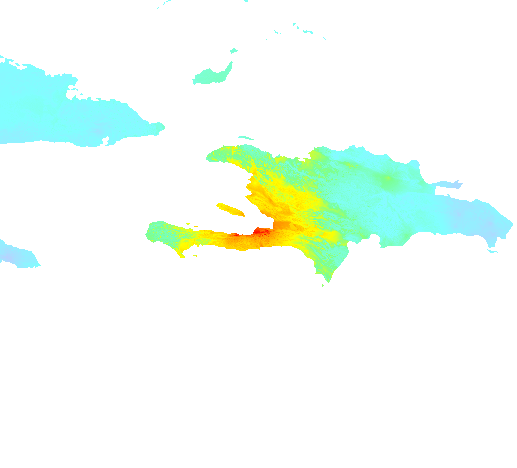

In [ ]:
import folium

center_lat = (north + south) / 2
center_lon = (east + west) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

overlay_img = os.path.join(extract_folder, "ii_overlay.png")

img_overlay = folium.raster_layers.ImageOverlay(
    name="ShakeMap Intensity",
    image=overlay_img,
    bounds=[[south, west], [north, east]],
    opacity=0.6
)
img_overlay.add_to(m)

folium.LayerControl().add_to(m)

m


### 14. Visualizing Earthquake Intensity vs. Distance from Epicenter
This code retrieves and visualizes earthquake intensity data from the USGS Did You Feel It? (DYFI) dataset. It plots how shaking intensity varies with distance from the epicenter, using a scatter plot for an intuitive representation of ground motion effects.


*   Fetches real-world earthquake data from USGS or loads a local file for analysis.
*   Parses and structures intensity data, making it suitable for visualization
*   Creates an interactive scatter plot to illustrate how shaking diminishes with distance.
*   Uses the Modified Mercalli Intensity (MMI) scale, a standard measure for earthquake effects.
*   Provides insights for disaster response, helping assess which areas felt the strongest shaking.


In [ ]:
import requests

url = "https://earthquake.usgs.gov/product/dyfi/usp000h60h/us/1702920267697/dyfi_plot_atten.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print("Failed to retrieve data")


{'datasets': [{'legend': 'All reported data', 'data': [{'y': 5.2, 'x': 235.8}, {'y': 2.9, 'x': 342.7}, {'y': 4.1, 'x': 240.3}, {'y': 4.1, 'x': 148.8}, {'y': 2.6, 'x': 692.4}, {'y': 4.3, 'x': 238.3}, {'y': 4.6, 'x': 231.5}, {'y': 2.9, 'x': 1049.2}, {'y': 2.2, 'x': 1155.3}, {'y': 3.4, 'x': 222.9}, {'y': 7.1, 'x': 40.9}, {'y': 2, 'x': 338.2}, {'y': 4, 'x': 282.5}, {'y': 3.8, 'x': 160.1}, {'y': 1, 'x': 885.9}, {'y': 3.4, 'x': 342.5}, {'y': 7.4, 'x': 144.8}, {'y': 7.1, 'x': 53.5}, {'y': 2.8, 'x': 294.3}, {'y': 3.2, 'x': 861.1}, {'y': 3.8, 'x': 115.5}, {'y': 1, 'x': 1196.9}, {'y': 5.3, 'x': 155.3}, {'y': 3.4, 'x': 451.9}, {'y': 2.5, 'x': 1130.5}, {'y': 2.2, 'x': 482.5}, {'y': 7.7, 'x': 34.3}, {'y': 2, 'x': 1173.5}, {'y': 2.9, 'x': 444.2}, {'y': 3.4, 'x': 255.6}, {'y': 2.6, 'x': 682.4}, {'y': 4.1, 'x': 199.5}, {'y': 1, 'x': 1008.3}, {'y': 8.4, 'x': 13.7}, {'y': 2, 'x': 2406.2}, {'y': 1, 'x': 353.9}, {'y': 7.3, 'x': 192.7}, {'y': 2, 'x': 434.3}, {'y': 4.8, 'x': 160.1}, {'y': 3.1, 'x': 222.6}, 

In [ ]:
import json

file_path = "/content/drive/MyDrive/Haiti Data/dyfi_plot_atten.json"

with open(file_path, "r") as f:
    data = json.load(f)

In [ ]:
import plotly.express as px
import pandas as pd
import json

file_path = "/content/drive/MyDrive/Haiti Data/dyfi_plot_atten.json"

with open(file_path, "r") as f:
    data = json.load(f)

all_data = data['datasets'][0]['data']
df = pd.DataFrame(all_data)

df.columns = ['Intensity (MMI)', 'Distance from Epicenter (km)']

fig = px.scatter(
    df,
    x='Distance from Epicenter (km)',
    y='Intensity (MMI)',
    color='Intensity (MMI)',
    size_max=10,
    color_continuous_scale="Viridis",
    title="Earthquake Intensity vs. Distance",
    labels={"Distance from Epicenter (km)": "Hypocentral Distance (km)",
            "Intensity (MMI)": "Modified Mercalli Intensity (MMI)"},
    hover_data=['Intensity (MMI)', 'Distance from Epicenter (km)']
)

fig.update_traces(marker=dict(size=7, opacity=0.7))
fig.update_layout(coloraxis_colorbar=dict(title="MMI Intensity"))

fig.show()


### Why This Matters: The Real-World Impact of This Project
Earthquakes cause massive destruction, but understanding where and how damage occurs is critical for improving disaster response and resilience. This project helps solve several key challenges:


*   **Rapid Damage Assessment** – By overlaying earthquake intensity maps with infrastructure data, first responders can prioritize search and rescue efforts in the hardest-hit areas.

*   **Data-Driven Disaster Response** – Traditional response strategies rely on delayed, manual assessments. This project automates damage detection using satellite imagery and GIS analysis, reducing response time.

*  **Urban Planning & Preparedness** – By analyzing past earthquakes, we can predict the most vulnerable areas and improve building codes, land use policies, and emergency planning.

*   **The project bridges the gap between scientific models** (USGS ShakeMap, DYFI reports) and real-world infrastructure damage, making earthquake risk more accessible and understandable.


### Closing Statement

This project isn’t just about numbers on a map. It’s about using data to save lives, prepare for the next disaster, and build a more resilient future.